In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import keras
from keras_unet.models import custom_unet


2023-01-09 21:35:26.413513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
labels = labels.astype(np.float64)

In [10]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


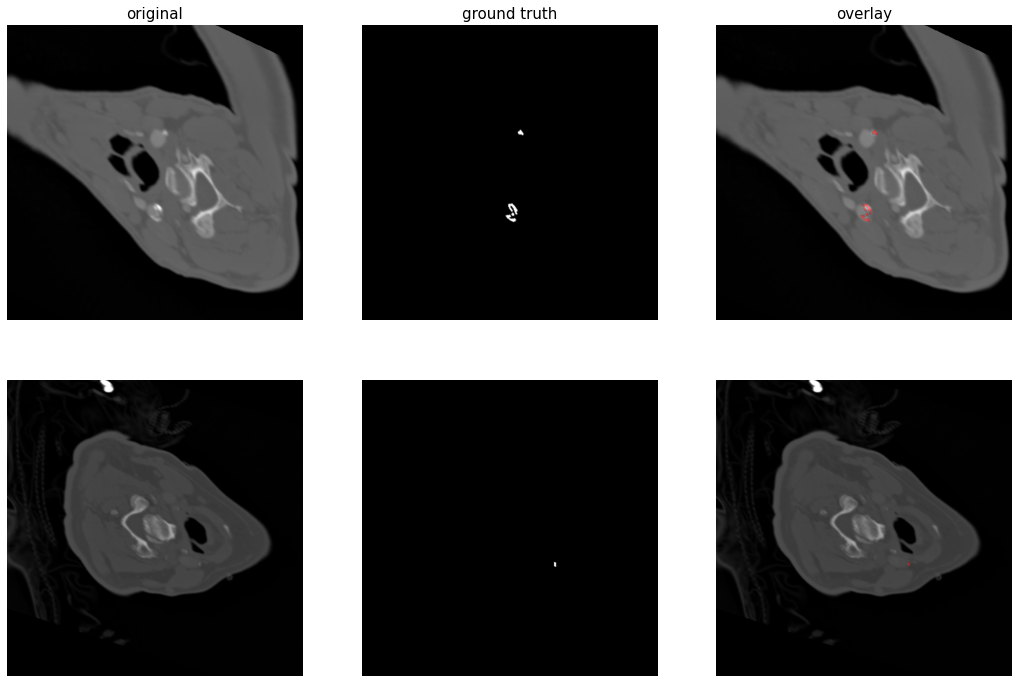

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [15]:

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-01-09 21:35:37.695667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-09 21:35:37.790875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-09 21:35:37.790920: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-09 21:35:37.849198: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-09 21:35:37.849234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-09 21:35:37.864836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [17]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [18]:
from keras.callbacks import EarlyStopping

earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_iou",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [19]:

from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [21]:
model.compile(optimizer = opt,    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [22]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=1000,
                    validation_data=(X_val, y_val),)
#                     callbacks = [earlystopping])

2023-01-09 21:35:40.285482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-09 21:35:40.288356: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/1000


2023-01-09 21:35:41.551018: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-09 21:35:42.830672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-01-09 21:35:44.387012: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-01-09 21:35:44.387039: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-01-09 21:35:44.387963: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-09 21:35:44.481913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-09 21:35:45.906177: I tensorflow/stream_exec

10/10 [==============================] - 45s 2s/step - loss: 4.0909 - iou: 6.4479e-05 - iou_thresholded: 5.9183e-04 - val_loss: 0.4823 - val_iou: 6.8216e-05 - val_iou_thresholded: 0.0015
Epoch 2/1000
10/10 [==============================] - 10s 960ms/step - loss: 0.2222 - iou: 7.2546e-05 - iou_thresholded: 6.0410e-04 - val_loss: 0.1183 - val_iou: 1.6118e-05 - val_iou_thresholded: 0.0015
Epoch 3/1000
10/10 [==============================] - 10s 957ms/step - loss: 0.0270 - iou: 1.9196e-04 - iou_thresholded: 5.8628e-04 - val_loss: 0.0045 - val_iou: 4.2749e-04 - val_iou_thresholded: 0.0015
Epoch 4/1000
10/10 [==============================] - 10s 954ms/step - loss: 0.0061 - iou: 9.5787e-05 - iou_thresholded: 5.9948e-04 - val_loss: 0.0041 - val_iou: 3.3565e-04 - val_iou_thresholded: 0.0015
Epoch 5/1000
10/10 [==============================] - 10s 957ms/step - loss: 0.0043 - iou: 2.0745e-04 - iou_thresholded: 5.8419e-04 - val_loss: 0.0034 - val_iou: 4.8690e-04 - val_iou_thresholded: 0.0015
E

10/10 [==============================] - 10s 960ms/step - loss: 7.2625e-04 - iou: 0.1634 - iou_thresholded: 0.2077 - val_loss: 7.1082e-04 - val_iou: 0.1021 - val_iou_thresholded: 0.0380
Epoch 84/1000
10/10 [==============================] - 10s 960ms/step - loss: 6.7621e-04 - iou: 0.1734 - iou_thresholded: 0.2559 - val_loss: 7.9421e-04 - val_iou: 0.0797 - val_iou_thresholded: 0.0164
Epoch 85/1000
10/10 [==============================] - 10s 955ms/step - loss: 6.9298e-04 - iou: 0.1808 - iou_thresholded: 0.2329 - val_loss: 6.7676e-04 - val_iou: 0.1181 - val_iou_thresholded: 0.0789
Epoch 86/1000
10/10 [==============================] - 10s 959ms/step - loss: 7.1935e-04 - iou: 0.1618 - iou_thresholded: 0.2378 - val_loss: 8.8341e-04 - val_iou: 0.0688 - val_iou_thresholded: 0.0123
Epoch 87/1000
10/10 [==============================] - 10s 955ms/step - loss: 7.1748e-04 - iou: 0.1763 - iou_thresholded: 0.2307 - val_loss: 6.9283e-04 - val_iou: 0.1056 - val_iou_thresholded: 0.0428
Epoch 88/1000


Epoch 124/1000
10/10 [==============================] - 10s 959ms/step - loss: 4.5797e-04 - iou: 0.3170 - iou_thresholded: 0.4264 - val_loss: 4.8965e-04 - val_iou: 0.2996 - val_iou_thresholded: 0.3611
Epoch 125/1000
10/10 [==============================] - 10s 959ms/step - loss: 4.8009e-04 - iou: 0.3113 - iou_thresholded: 0.4206 - val_loss: 4.6733e-04 - val_iou: 0.3038 - val_iou_thresholded: 0.4394
Epoch 126/1000
10/10 [==============================] - 10s 956ms/step - loss: 4.8040e-04 - iou: 0.3112 - iou_thresholded: 0.4257 - val_loss: 4.9768e-04 - val_iou: 0.3035 - val_iou_thresholded: 0.3462
Epoch 127/1000
10/10 [==============================] - 10s 959ms/step - loss: 4.6708e-04 - iou: 0.3138 - iou_thresholded: 0.4165 - val_loss: 4.5071e-04 - val_iou: 0.3130 - val_iou_thresholded: 0.4397
Epoch 128/1000
10/10 [==============================] - 10s 956ms/step - loss: 4.4371e-04 - iou: 0.3324 - iou_thresholded: 0.4610 - val_loss: 4.5545e-04 - val_iou: 0.3175 - val_iou_thresholded: 0.

Epoch 165/1000
10/10 [==============================] - 10s 959ms/step - loss: 3.4691e-04 - iou: 0.4243 - iou_thresholded: 0.5488 - val_loss: 3.8158e-04 - val_iou: 0.4075 - val_iou_thresholded: 0.5510
Epoch 166/1000
10/10 [==============================] - 10s 956ms/step - loss: 3.3872e-04 - iou: 0.4267 - iou_thresholded: 0.5504 - val_loss: 3.9487e-04 - val_iou: 0.3955 - val_iou_thresholded: 0.5701
Epoch 167/1000
10/10 [==============================] - 10s 958ms/step - loss: 3.4702e-04 - iou: 0.4335 - iou_thresholded: 0.5556 - val_loss: 3.9853e-04 - val_iou: 0.4249 - val_iou_thresholded: 0.5286
Epoch 168/1000
10/10 [==============================] - 10s 955ms/step - loss: 3.4025e-04 - iou: 0.4421 - iou_thresholded: 0.5663 - val_loss: 4.0789e-04 - val_iou: 0.3851 - val_iou_thresholded: 0.5707
Epoch 169/1000
10/10 [==============================] - 10s 959ms/step - loss: 3.3971e-04 - iou: 0.4351 - iou_thresholded: 0.5588 - val_loss: 3.9470e-04 - val_iou: 0.4319 - val_iou_thresholded: 0.

Epoch 206/1000
10/10 [==============================] - 10s 955ms/step - loss: 2.6666e-04 - iou: 0.5225 - iou_thresholded: 0.6299 - val_loss: 4.1034e-04 - val_iou: 0.4154 - val_iou_thresholded: 0.5712
Epoch 207/1000
10/10 [==============================] - 10s 959ms/step - loss: 2.6636e-04 - iou: 0.5110 - iou_thresholded: 0.6301 - val_loss: 3.8339e-04 - val_iou: 0.4444 - val_iou_thresholded: 0.5743
Epoch 208/1000
10/10 [==============================] - 10s 955ms/step - loss: 2.5730e-04 - iou: 0.5248 - iou_thresholded: 0.6298 - val_loss: 3.8386e-04 - val_iou: 0.4557 - val_iou_thresholded: 0.5786
Epoch 209/1000
10/10 [==============================] - 10s 959ms/step - loss: 2.6874e-04 - iou: 0.5127 - iou_thresholded: 0.6223 - val_loss: 3.8470e-04 - val_iou: 0.4463 - val_iou_thresholded: 0.5855
Epoch 210/1000
10/10 [==============================] - 10s 959ms/step - loss: 2.5801e-04 - iou: 0.5156 - iou_thresholded: 0.6310 - val_loss: 3.7408e-04 - val_iou: 0.4385 - val_iou_thresholded: 0.

Epoch 247/1000
10/10 [==============================] - 10s 958ms/step - loss: 1.9233e-04 - iou: 0.6192 - iou_thresholded: 0.7174 - val_loss: 3.9633e-04 - val_iou: 0.4845 - val_iou_thresholded: 0.5885
Epoch 248/1000
10/10 [==============================] - 10s 955ms/step - loss: 1.9740e-04 - iou: 0.6015 - iou_thresholded: 0.6996 - val_loss: 4.0022e-04 - val_iou: 0.4540 - val_iou_thresholded: 0.5819
Epoch 249/1000
10/10 [==============================] - 10s 959ms/step - loss: 2.0132e-04 - iou: 0.6083 - iou_thresholded: 0.7127 - val_loss: 4.2735e-04 - val_iou: 0.4567 - val_iou_thresholded: 0.5534
Epoch 250/1000
10/10 [==============================] - 10s 959ms/step - loss: 1.9480e-04 - iou: 0.6173 - iou_thresholded: 0.7140 - val_loss: 4.0075e-04 - val_iou: 0.4444 - val_iou_thresholded: 0.5810
Epoch 251/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.9749e-04 - iou: 0.6078 - iou_thresholded: 0.7122 - val_loss: 3.8486e-04 - val_iou: 0.4851 - val_iou_thresholded: 0.

Epoch 288/1000
10/10 [==============================] - 10s 956ms/step - loss: 1.4079e-04 - iou: 0.6898 - iou_thresholded: 0.7760 - val_loss: 4.3385e-04 - val_iou: 0.4870 - val_iou_thresholded: 0.5759
Epoch 289/1000
10/10 [==============================] - 10s 955ms/step - loss: 1.4432e-04 - iou: 0.6963 - iou_thresholded: 0.7779 - val_loss: 4.2790e-04 - val_iou: 0.4830 - val_iou_thresholded: 0.5677
Epoch 290/1000
10/10 [==============================] - 10s 966ms/step - loss: 1.4716e-04 - iou: 0.6871 - iou_thresholded: 0.7716 - val_loss: 4.3913e-04 - val_iou: 0.4695 - val_iou_thresholded: 0.5542
Epoch 291/1000
10/10 [==============================] - 10s 957ms/step - loss: 1.4666e-04 - iou: 0.6778 - iou_thresholded: 0.7707 - val_loss: 4.4391e-04 - val_iou: 0.4900 - val_iou_thresholded: 0.5679
Epoch 292/1000
10/10 [==============================] - 10s 955ms/step - loss: 1.5130e-04 - iou: 0.6857 - iou_thresholded: 0.7692 - val_loss: 4.2847e-04 - val_iou: 0.4781 - val_iou_thresholded: 0.

Epoch 329/1000
10/10 [==============================] - 10s 957ms/step - loss: 9.8528e-05 - iou: 0.7727 - iou_thresholded: 0.8442 - val_loss: 4.8487e-04 - val_iou: 0.5110 - val_iou_thresholded: 0.5623
Epoch 330/1000
10/10 [==============================] - 10s 958ms/step - loss: 9.3930e-05 - iou: 0.7816 - iou_thresholded: 0.8516 - val_loss: 4.8982e-04 - val_iou: 0.4907 - val_iou_thresholded: 0.5418
Epoch 331/1000
10/10 [==============================] - 10s 958ms/step - loss: 9.6322e-05 - iou: 0.7745 - iou_thresholded: 0.8434 - val_loss: 5.0800e-04 - val_iou: 0.5048 - val_iou_thresholded: 0.5573
Epoch 332/1000
10/10 [==============================] - 10s 954ms/step - loss: 9.5475e-05 - iou: 0.7760 - iou_thresholded: 0.8450 - val_loss: 5.2597e-04 - val_iou: 0.4992 - val_iou_thresholded: 0.5429
Epoch 333/1000
10/10 [==============================] - 10s 962ms/step - loss: 9.7655e-05 - iou: 0.7802 - iou_thresholded: 0.8466 - val_loss: 5.0972e-04 - val_iou: 0.4796 - val_iou_thresholded: 0.

Epoch 370/1000
10/10 [==============================] - 10s 956ms/step - loss: 6.6579e-05 - iou: 0.8376 - iou_thresholded: 0.8940 - val_loss: 5.8507e-04 - val_iou: 0.5252 - val_iou_thresholded: 0.5602
Epoch 371/1000
10/10 [==============================] - 10s 960ms/step - loss: 6.4890e-05 - iou: 0.8390 - iou_thresholded: 0.8980 - val_loss: 5.7918e-04 - val_iou: 0.5227 - val_iou_thresholded: 0.5573
Epoch 372/1000
10/10 [==============================] - 10s 955ms/step - loss: 6.2668e-05 - iou: 0.8478 - iou_thresholded: 0.9034 - val_loss: 6.2283e-04 - val_iou: 0.5261 - val_iou_thresholded: 0.5591
Epoch 373/1000
10/10 [==============================] - 10s 957ms/step - loss: 6.3149e-05 - iou: 0.8486 - iou_thresholded: 0.8997 - val_loss: 5.9405e-04 - val_iou: 0.5158 - val_iou_thresholded: 0.5508
Epoch 374/1000
10/10 [==============================] - 10s 954ms/step - loss: 6.4702e-05 - iou: 0.8436 - iou_thresholded: 0.9017 - val_loss: 6.4855e-04 - val_iou: 0.5253 - val_iou_thresholded: 0.

Epoch 411/1000
10/10 [==============================] - 10s 958ms/step - loss: 5.8765e-05 - iou: 0.8799 - iou_thresholded: 0.9227 - val_loss: 6.8383e-04 - val_iou: 0.5177 - val_iou_thresholded: 0.5485
Epoch 412/1000
10/10 [==============================] - 10s 961ms/step - loss: 5.3531e-05 - iou: 0.8754 - iou_thresholded: 0.9199 - val_loss: 7.5459e-04 - val_iou: 0.5288 - val_iou_thresholded: 0.5479
Epoch 413/1000
10/10 [==============================] - 10s 954ms/step - loss: 4.9949e-05 - iou: 0.8788 - iou_thresholded: 0.9211 - val_loss: 7.2489e-04 - val_iou: 0.5121 - val_iou_thresholded: 0.5408
Epoch 414/1000
10/10 [==============================] - 10s 957ms/step - loss: 4.4592e-05 - iou: 0.8917 - iou_thresholded: 0.9348 - val_loss: 7.8783e-04 - val_iou: 0.5292 - val_iou_thresholded: 0.5461
Epoch 415/1000
10/10 [==============================] - 10s 954ms/step - loss: 4.5629e-05 - iou: 0.8890 - iou_thresholded: 0.9297 - val_loss: 7.3076e-04 - val_iou: 0.5155 - val_iou_thresholded: 0.

Epoch 452/1000
10/10 [==============================] - 10s 957ms/step - loss: 1.3743e-04 - iou: 0.7904 - iou_thresholded: 0.8317 - val_loss: 6.8790e-04 - val_iou: 0.4571 - val_iou_thresholded: 0.5084
Epoch 453/1000
10/10 [==============================] - 10s 958ms/step - loss: 1.3632e-04 - iou: 0.7616 - iou_thresholded: 0.8226 - val_loss: 6.8532e-04 - val_iou: 0.4570 - val_iou_thresholded: 0.5003
Epoch 454/1000
10/10 [==============================] - 10s 962ms/step - loss: 1.6149e-04 - iou: 0.7183 - iou_thresholded: 0.7905 - val_loss: 6.2748e-04 - val_iou: 0.4470 - val_iou_thresholded: 0.5041
Epoch 455/1000
10/10 [==============================] - 10s 958ms/step - loss: 5.7825e-04 - iou: 0.4621 - iou_thresholded: 0.5505 - val_loss: 6.7979e-04 - val_iou: 0.2102 - val_iou_thresholded: 0.3075
Epoch 456/1000
10/10 [==============================] - 10s 959ms/step - loss: 4.9193e-04 - iou: 0.3910 - iou_thresholded: 0.5003 - val_loss: 0.0012 - val_iou: 0.1337 - val_iou_thresholded: 0.4049

Epoch 493/1000
10/10 [==============================] - 10s 961ms/step - loss: 3.5588e-05 - iou: 0.9075 - iou_thresholded: 0.9461 - val_loss: 7.4033e-04 - val_iou: 0.5226 - val_iou_thresholded: 0.5480
Epoch 494/1000
10/10 [==============================] - 10s 955ms/step - loss: 3.7900e-05 - iou: 0.9089 - iou_thresholded: 0.9457 - val_loss: 7.4448e-04 - val_iou: 0.5164 - val_iou_thresholded: 0.5411
Epoch 495/1000
10/10 [==============================] - 10s 958ms/step - loss: 3.8879e-05 - iou: 0.9122 - iou_thresholded: 0.9469 - val_loss: 7.5966e-04 - val_iou: 0.5187 - val_iou_thresholded: 0.5378
Epoch 496/1000
10/10 [==============================] - 10s 954ms/step - loss: 4.4118e-05 - iou: 0.8962 - iou_thresholded: 0.9366 - val_loss: 7.2304e-04 - val_iou: 0.5364 - val_iou_thresholded: 0.5592
Epoch 497/1000
10/10 [==============================] - 10s 956ms/step - loss: 4.0834e-05 - iou: 0.9081 - iou_thresholded: 0.9468 - val_loss: 7.1102e-04 - val_iou: 0.5232 - val_iou_thresholded: 0.

Epoch 534/1000
10/10 [==============================] - 10s 958ms/step - loss: 1.3484e-05 - iou: 0.9650 - iou_thresholded: 0.9816 - val_loss: 0.0011 - val_iou: 0.5429 - val_iou_thresholded: 0.5532
Epoch 535/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.1552e-05 - iou: 0.9670 - iou_thresholded: 0.9839 - val_loss: 0.0011 - val_iou: 0.5464 - val_iou_thresholded: 0.5548
Epoch 536/1000
10/10 [==============================] - 10s 957ms/step - loss: 1.0858e-05 - iou: 0.9725 - iou_thresholded: 0.9871 - val_loss: 0.0011 - val_iou: 0.5455 - val_iou_thresholded: 0.5510
Epoch 537/1000
10/10 [==============================] - 10s 954ms/step - loss: 9.6102e-06 - iou: 0.9733 - iou_thresholded: 0.9872 - val_loss: 0.0011 - val_iou: 0.5429 - val_iou_thresholded: 0.5527
Epoch 538/1000
10/10 [==============================] - 10s 958ms/step - loss: 8.3607e-06 - iou: 0.9765 - iou_thresholded: 0.9896 - val_loss: 0.0012 - val_iou: 0.5437 - val_iou_thresholded: 0.5512
Epoch 539/1000


Epoch 617/1000
10/10 [==============================] - 10s 960ms/step - loss: 7.8907e-06 - iou: 0.9838 - iou_thresholded: 0.9915 - val_loss: 0.0013 - val_iou: 0.5370 - val_iou_thresholded: 0.5428
Epoch 618/1000
10/10 [==============================] - 10s 956ms/step - loss: 1.7945e-05 - iou: 0.9720 - iou_thresholded: 0.9814 - val_loss: 0.0012 - val_iou: 0.5266 - val_iou_thresholded: 0.5300
Epoch 619/1000
10/10 [==============================] - 10s 958ms/step - loss: 1.2505e-05 - iou: 0.9728 - iou_thresholded: 0.9834 - val_loss: 0.0012 - val_iou: 0.5262 - val_iou_thresholded: 0.5332
Epoch 620/1000
10/10 [==============================] - 10s 954ms/step - loss: 9.8683e-06 - iou: 0.9758 - iou_thresholded: 0.9861 - val_loss: 0.0012 - val_iou: 0.5310 - val_iou_thresholded: 0.5377
Epoch 621/1000
10/10 [==============================] - 10s 960ms/step - loss: 1.0461e-05 - iou: 0.9732 - iou_thresholded: 0.9857 - val_loss: 0.0012 - val_iou: 0.5328 - val_iou_thresholded: 0.5427
Epoch 622/1000


Epoch 700/1000
10/10 [==============================] - 10s 955ms/step - loss: 4.1300e-06 - iou: 0.9894 - iou_thresholded: 0.9951 - val_loss: 0.0015 - val_iou: 0.5407 - val_iou_thresholded: 0.5411
Epoch 701/1000
10/10 [==============================] - 10s 956ms/step - loss: 3.2168e-06 - iou: 0.9920 - iou_thresholded: 0.9959 - val_loss: 0.0015 - val_iou: 0.5462 - val_iou_thresholded: 0.5496
Epoch 702/1000
10/10 [==============================] - 10s 954ms/step - loss: 3.4718e-06 - iou: 0.9909 - iou_thresholded: 0.9959 - val_loss: 0.0014 - val_iou: 0.5459 - val_iou_thresholded: 0.5487
Epoch 703/1000
10/10 [==============================] - 10s 960ms/step - loss: 2.2461e-06 - iou: 0.9935 - iou_thresholded: 0.9970 - val_loss: 0.0015 - val_iou: 0.5486 - val_iou_thresholded: 0.5539
Epoch 704/1000
10/10 [==============================] - 10s 955ms/step - loss: 6.9282e-06 - iou: 0.9877 - iou_thresholded: 0.9927 - val_loss: 0.0016 - val_iou: 0.5376 - val_iou_thresholded: 0.5417
Epoch 705/1000


10/10 [==============================] - 10s 956ms/step - loss: 1.5425e-05 - iou: 0.9619 - iou_thresholded: 0.9787 - val_loss: 8.8415e-04 - val_iou: 0.5347 - val_iou_thresholded: 0.5482
Epoch 783/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.6996e-05 - iou: 0.9603 - iou_thresholded: 0.9782 - val_loss: 8.5614e-04 - val_iou: 0.5397 - val_iou_thresholded: 0.5529
Epoch 784/1000
10/10 [==============================] - 10s 962ms/step - loss: 1.6601e-05 - iou: 0.9583 - iou_thresholded: 0.9745 - val_loss: 8.3555e-04 - val_iou: 0.5367 - val_iou_thresholded: 0.5468
Epoch 785/1000
10/10 [==============================] - 10s 958ms/step - loss: 4.3836e-05 - iou: 0.9334 - iou_thresholded: 0.9588 - val_loss: 0.0011 - val_iou: 0.4818 - val_iou_thresholded: 0.4888
Epoch 786/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.3017e-04 - iou: 0.8374 - iou_thresholded: 0.8710 - val_loss: 6.7983e-04 - val_iou: 0.4452 - val_iou_thresholded: 0.5084
Epoch 787/1000

Epoch 865/1000
10/10 [==============================] - 10s 958ms/step - loss: 4.7929e-06 - iou: 0.9881 - iou_thresholded: 0.9947 - val_loss: 0.0013 - val_iou: 0.5300 - val_iou_thresholded: 0.5311
Epoch 866/1000
10/10 [==============================] - 10s 958ms/step - loss: 4.9625e-06 - iou: 0.9896 - iou_thresholded: 0.9950 - val_loss: 0.0012 - val_iou: 0.5318 - val_iou_thresholded: 0.5343
Epoch 867/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.3323e-05 - iou: 0.9855 - iou_thresholded: 0.9909 - val_loss: 0.0013 - val_iou: 0.4894 - val_iou_thresholded: 0.4947
Epoch 868/1000
10/10 [==============================] - 10s 957ms/step - loss: 1.4646e-04 - iou: 0.8590 - iou_thresholded: 0.8875 - val_loss: 8.0518e-04 - val_iou: 0.4439 - val_iou_thresholded: 0.4650
Epoch 869/1000
10/10 [==============================] - 10s 954ms/step - loss: 1.4351e-04 - iou: 0.7575 - iou_thresholded: 0.8139 - val_loss: 5.3889e-04 - val_iou: 0.4396 - val_iou_thresholded: 0.5154
Epoch 8

Epoch 906/1000
10/10 [==============================] - 10s 960ms/step - loss: 1.0280e-05 - iou: 0.9758 - iou_thresholded: 0.9875 - val_loss: 0.0010 - val_iou: 0.5385 - val_iou_thresholded: 0.5416
Epoch 907/1000
10/10 [==============================] - 10s 958ms/step - loss: 6.6473e-06 - iou: 0.9809 - iou_thresholded: 0.9911 - val_loss: 0.0010 - val_iou: 0.5372 - val_iou_thresholded: 0.5437
Epoch 908/1000
10/10 [==============================] - 10s 957ms/step - loss: 6.5649e-06 - iou: 0.9842 - iou_thresholded: 0.9920 - val_loss: 0.0011 - val_iou: 0.5369 - val_iou_thresholded: 0.5453
Epoch 909/1000
10/10 [==============================] - 10s 954ms/step - loss: 7.0077e-06 - iou: 0.9838 - iou_thresholded: 0.9918 - val_loss: 0.0011 - val_iou: 0.5333 - val_iou_thresholded: 0.5419
Epoch 910/1000
10/10 [==============================] - 10s 956ms/step - loss: 8.6080e-06 - iou: 0.9844 - iou_thresholded: 0.9914 - val_loss: 0.0011 - val_iou: 0.5333 - val_iou_thresholded: 0.5370
Epoch 911/1000


Epoch 989/1000
10/10 [==============================] - 10s 955ms/step - loss: 1.3791e-05 - iou: 0.9728 - iou_thresholded: 0.9835 - val_loss: 0.0010 - val_iou: 0.5245 - val_iou_thresholded: 0.5349
Epoch 990/1000
10/10 [==============================] - 10s 957ms/step - loss: 1.3137e-05 - iou: 0.9729 - iou_thresholded: 0.9834 - val_loss: 9.4542e-04 - val_iou: 0.5332 - val_iou_thresholded: 0.5441
Epoch 991/1000
10/10 [==============================] - 10s 955ms/step - loss: 1.8332e-05 - iou: 0.9652 - iou_thresholded: 0.9788 - val_loss: 8.5682e-04 - val_iou: 0.5267 - val_iou_thresholded: 0.5356
Epoch 992/1000
10/10 [==============================] - 10s 956ms/step - loss: 1.8417e-05 - iou: 0.9593 - iou_thresholded: 0.9769 - val_loss: 8.6536e-04 - val_iou: 0.5266 - val_iou_thresholded: 0.5385
Epoch 993/1000
10/10 [==============================] - 10s 961ms/step - loss: 1.4852e-05 - iou: 0.9692 - iou_thresholded: 0.9827 - val_loss: 9.6219e-04 - val_iou: 0.5278 - val_iou_thresholded: 0.5343

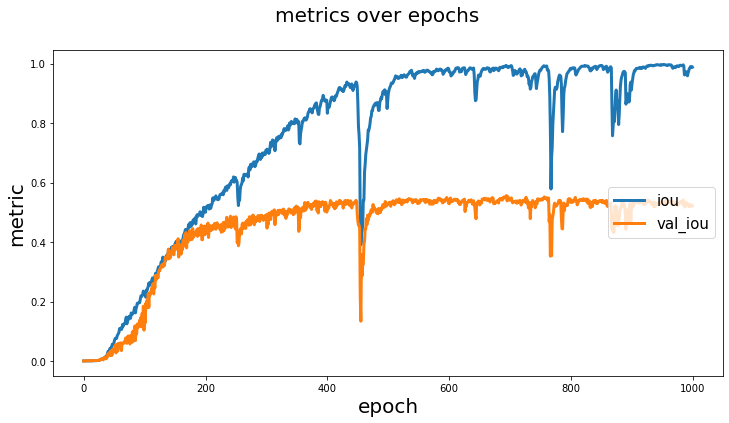

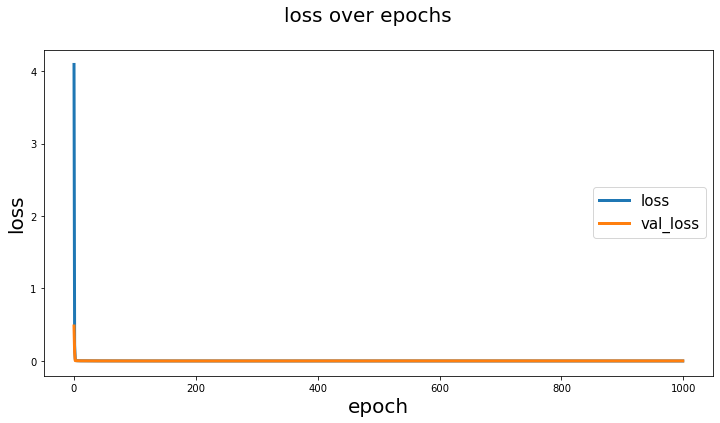

In [23]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [24]:
y_pred = model.predict(X_test)

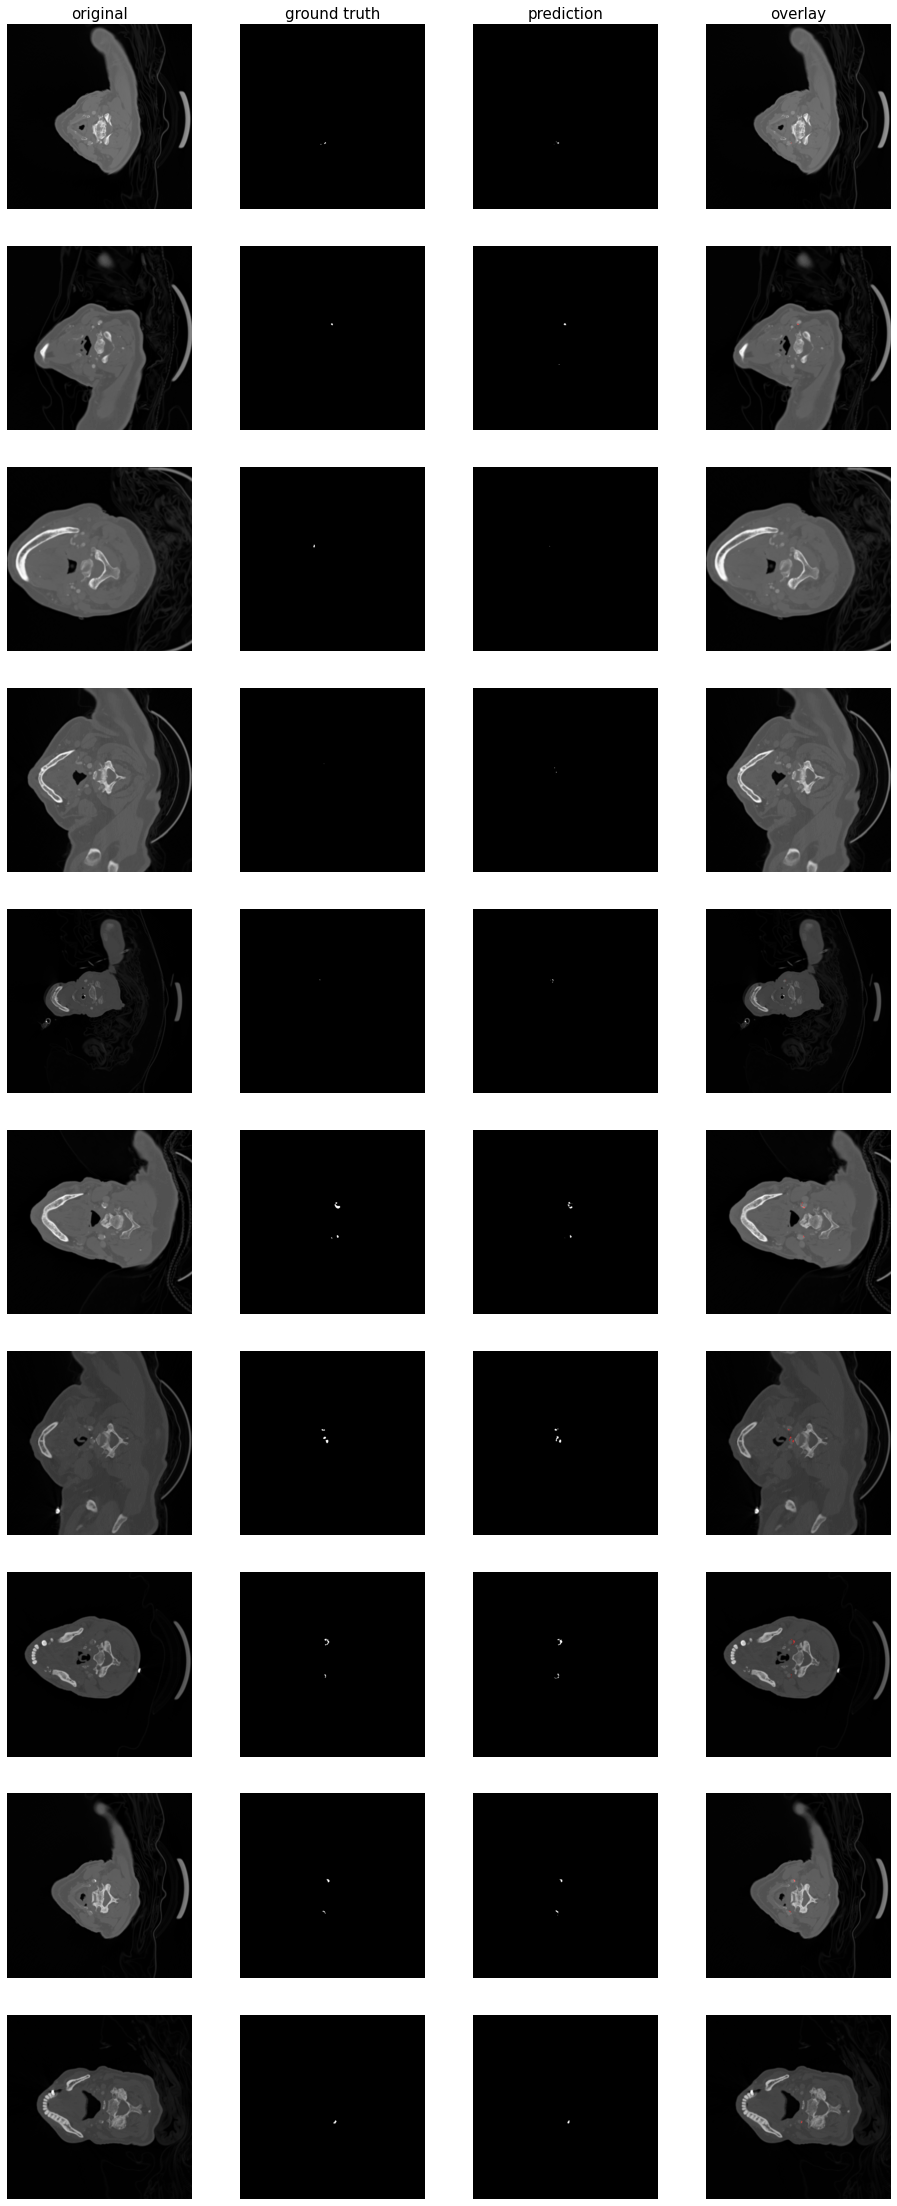

In [25]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [26]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 162ms/step - loss: 0.0011 - iou: 0.4864 - iou_thresholded: 0.4902


In [27]:
import mahotas as mh

In [28]:
image = X_test[0]

In [29]:
image.shape

(512, 512, 1)

In [30]:
label = y_test[0]

In [31]:
pred = y_pred[0]

In [32]:
bbox = mh.bbox(label)
incr=30

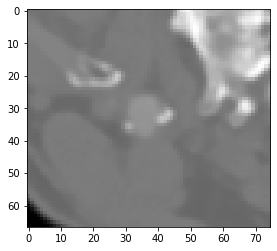

In [33]:
imshow(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:],cmap='gray')

In [34]:
X_test_c = []
y_test_c = []
y_pred_c = []

for i,z in enumerate(X_test):
    
    image = X_test[i]
    label = y_test[i]
    pred = y_pred[i]
    
    bbox = mh.bbox(label)
    incr=30
    X_test_c.append(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_test_c.append(label[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_pred_c.append(pred[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])


In [35]:
maxX = 0
maxY = 0

for i,z in enumerate(X_test_c):
    
    maxX = max(z.shape[1], maxX)
    maxY = max(z.shape[0], maxY)
    
X_test_c_np = np.zeros((len(X_test_c), maxY, maxX,1), dtype=X_test.dtype)
y_test_c_np = np.zeros((len(y_test_c), maxY, maxX,1), dtype=y_test.dtype)
y_pred_c_np = np.zeros((len(y_pred_c), maxY, maxX,1), dtype=y_pred.dtype)

for i,z in enumerate(X_test_c):
    
    image = X_test_c[i]
    label = y_test_c[i]
    pred = y_pred_c[i]
    
    X_test_c_np[i][0:image.shape[0], 0:image.shape[1],:] = image
    y_test_c_np[i][0:label.shape[0], 0:label.shape[1],:] = label
    y_pred_c_np[i][0:pred.shape[0], 0:pred.shape[1],:] = pred
    

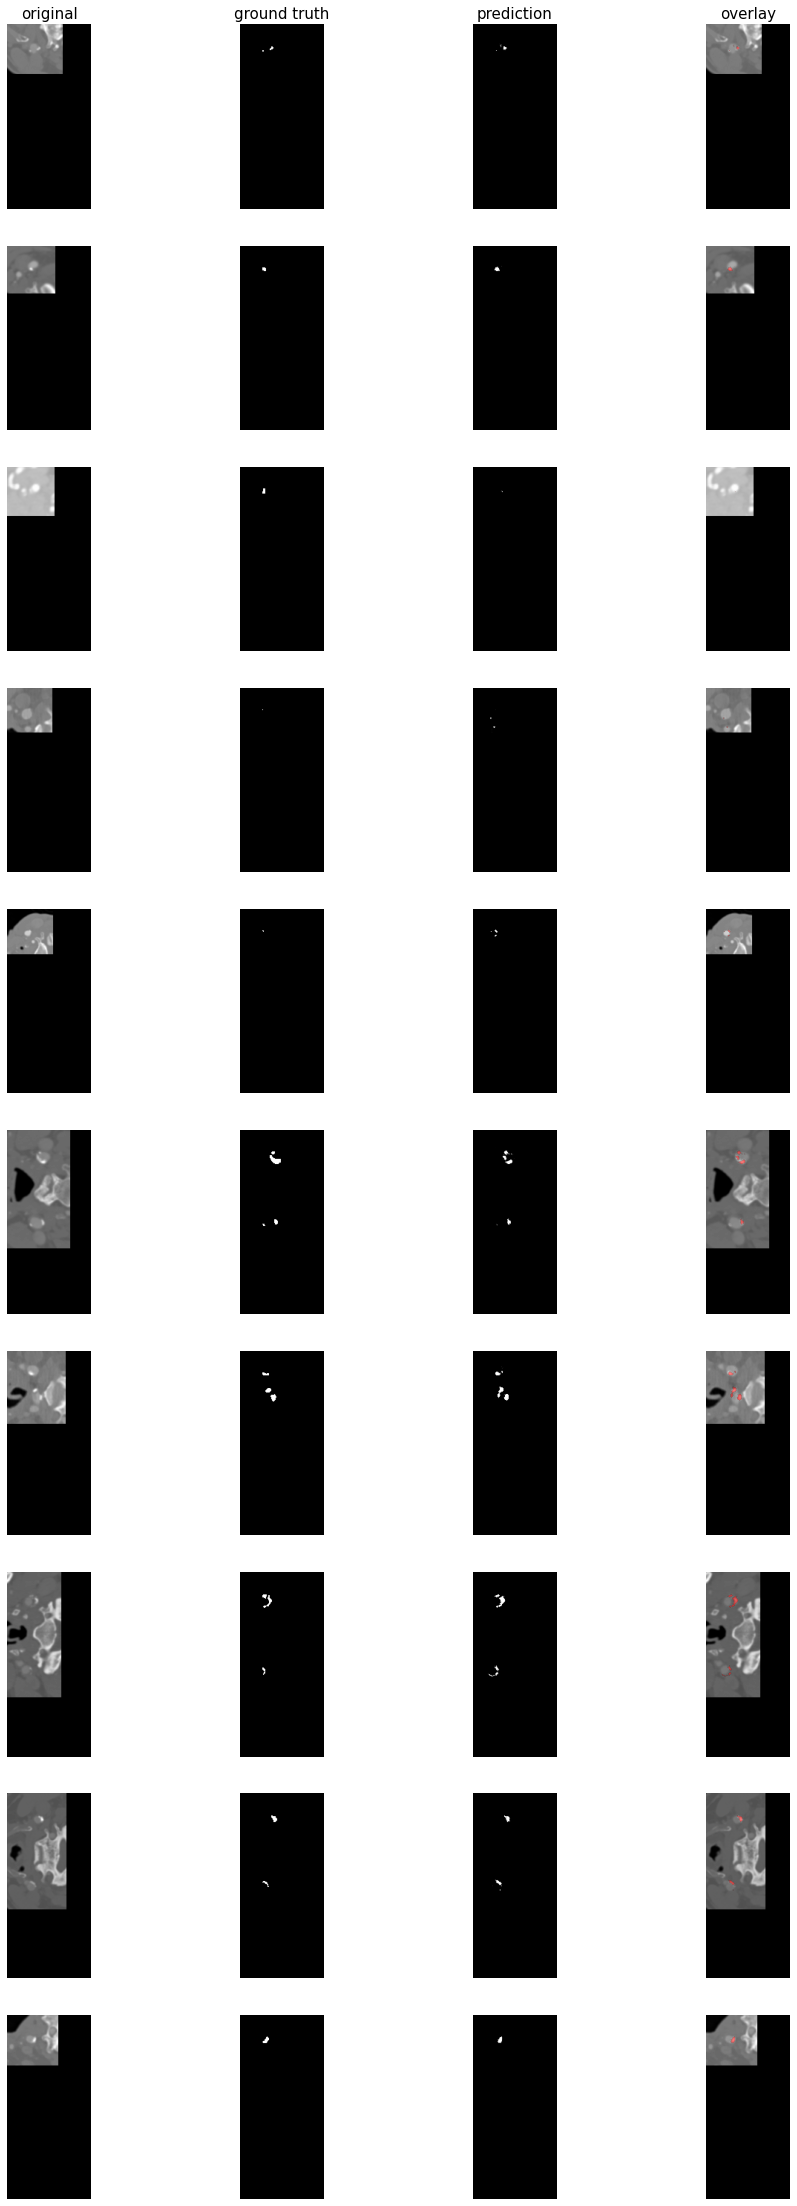

In [36]:
plot_imgs(org_imgs=X_test_c_np, mask_imgs=y_test_c_np, pred_imgs=y_pred_c_np)